<a href="https://colab.research.google.com/github/aparnasreedharan/Sound-Data/blob/main/pytorch_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install soundata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 34.6 MB/s eta 0:00:00
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64901 sha256=3cb6c5377d30c73efdf57e4ef93845cfc96ade1a9891d4

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import soundata
import librosa
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report



In [3]:
dataset = soundata.initialize('urbansound8k')

# Path to the UrbanSound8K.tar.gz file
file_path = os.path.join(dataset.data_home, "UrbanSound8K.tar.gz")

# Delete the existing .tar.gz file if it exists
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Deleted existing file: {file_path}")

#Delete the folder if it exists
extracted_folder = os.path.join(dataset.data_home, "UrbanSound8K")
if os.path.exists(extracted_folder):
    import shutil
    shutil.rmtree(extracted_folder)
    print(f"Deleted existing folder: {extracted_folder}")

#download the dataset
dataset.download()
dataset.validate()

5.61GB [08:32, 11.8MB/s]                            
1.15MB [00:01, 736kB/s]                             
100%|██████████| 8732/8732 [00:44<00:00, 196.55it/s]


({'metadata': {}, 'clips': {}}, {'metadata': {}, 'clips': {}})

In [4]:
#Verify contents
base_audio_path = "/root/sound_datasets/urbansound8k"

print("Contents of the dataset directory:")
print(os.listdir(base_audio_path))

#Check the audio subdirectory
audio_path = os.path.join(base_audio_path, "audio")
if os.path.exists(audio_path):
    print("Contents of the audio directory:")
    print(os.listdir(audio_path))
else:
    print("Audio directory not found!")


Contents of the dataset directory:
['UrbanSound8K_README.txt', 'UrbanSound8K.tar.gz', 'audio', 'metadata', 'FREESOUNDCREDITS.txt']
Contents of the audio directory:
['fold10', 'fold2', 'fold8', 'fold3', 'fold1', 'fold6', 'fold7', 'fold5', '.DS_Store', 'fold9', 'fold4']


In [5]:
#Path to metadata file
metadata_path = os.path.join(base_audio_path, "metadata/UrbanSound8K.csv")

#Load metadata
urban_sound_data = pd.read_csv(metadata_path)

#Verify the structure of metadata
print(urban_sound_data.head())

#Add a file_path column to locate audio files
urban_sound_data['file_path'] = urban_sound_data.apply(
    lambda row: os.path.join(base_audio_path, f"audio/fold{row['fold']}", row['slice_file_name']),
    axis=1
)

#Verify metadata
print(urban_sound_data[['slice_file_name', 'fold', 'file_path']].head())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
      slice_file_name  fold                                          file_path
0    100032-3-0-0.wav     5  /root/sound_datasets/urbansound8k/audio/fold5/...
1  100263-2-0-117.wav     5  /root/sound_datasets/urbansound8k/audio/fold5/...
2  100263-2-0-121.wav     5  /root/sound_datasets/urbansound8k/audio/fold5/...
3  100263-2-0-126.wav     5  /root/sound_datasets/urbansound8k/audio/fold5/...
4  100263-2-0-13

In [6]:
#Function to generate spectrograms
def generate_spectrogram(file_path, n_mels=128, duration=4.0, sr=22050):
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        return librosa.power_to_db(mel_spectrogram, ref=np.max)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

#Normalize spectrograms
def preprocess_spectrogram(spectrogram):
    return (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

#Resize spectrograms to a fixed shape
def resize_spectrogram(spectrogram, target_shape=(128, 128)):
    return resize(spectrogram, target_shape, mode='constant', anti_aliasing=True)

#Prepare spectrograms and labels
spectrograms, labels = [], []

for _, row in urban_sound_data.iterrows():
    spectrogram = generate_spectrogram(row['file_path'])
    if spectrogram is not None:
        spectrogram = preprocess_spectrogram(spectrogram)
        spectrogram = resize_spectrogram(spectrogram)
        spectrograms.append(spectrogram)
        labels.append(row['classID'])

spectrograms = np.array(spectrograms)
labels = np.array(labels)

print(f"Generated {len(spectrograms)} spectrograms.")


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Generated 8732 spectrograms.


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(spectrograms, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (6112, 128, 128), Validation set: (1310, 128, 128), Test set: (1310, 128, 128)


In [8]:
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.tensor(spectrograms, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        x = self.spectrograms[idx].unsqueeze(0)
        y = self.labels[idx]
        return x, y


In [9]:
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [10]:
#Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectrogramCNN(num_classes=len(np.unique(labels))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

train_dataset = SpectrogramDataset(X_train, y_train)
val_dataset = SpectrogramDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



#Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

 #Validation loop
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total


    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")



Epoch 1/20, Train Loss: 1.9395, Val Loss: 1.6140, Val Accuracy: 0.4595
Epoch 2/20, Train Loss: 1.5482, Val Loss: 1.3604, Val Accuracy: 0.5672
Epoch 3/20, Train Loss: 1.3406, Val Loss: 1.1644, Val Accuracy: 0.6221
Epoch 4/20, Train Loss: 1.1696, Val Loss: 1.0638, Val Accuracy: 0.6611
Epoch 5/20, Train Loss: 1.0261, Val Loss: 0.8908, Val Accuracy: 0.7130
Epoch 6/20, Train Loss: 0.9041, Val Loss: 0.8076, Val Accuracy: 0.7618
Epoch 7/20, Train Loss: 0.7958, Val Loss: 0.7173, Val Accuracy: 0.7710
Epoch 8/20, Train Loss: 0.6998, Val Loss: 0.6528, Val Accuracy: 0.8015
Epoch 9/20, Train Loss: 0.6326, Val Loss: 0.6103, Val Accuracy: 0.8130
Epoch 10/20, Train Loss: 0.5617, Val Loss: 0.5630, Val Accuracy: 0.8198
Epoch 11/20, Train Loss: 0.5203, Val Loss: 0.5203, Val Accuracy: 0.8344
Epoch 12/20, Train Loss: 0.4568, Val Loss: 0.5327, Val Accuracy: 0.8260
Epoch 13/20, Train Loss: 0.4068, Val Loss: 0.4407, Val Accuracy: 0.8481
Epoch 14/20, Train Loss: 0.3616, Val Loss: 0.4715, Val Accuracy: 0.8427
E

In [11]:
#Save the best model
torch.save(model.state_dict(), 'best_model.pth')

#Load the model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


<ipython-input-11-aba7166d2f50>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


SpectrogramCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [12]:
#Test dataset and DataLoader
test_dataset = SpectrogramDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Evaluate
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        test_loss += criterion(outputs, y_batch).item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_loss /= len(test_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.4472, Test Accuracy: 0.8649


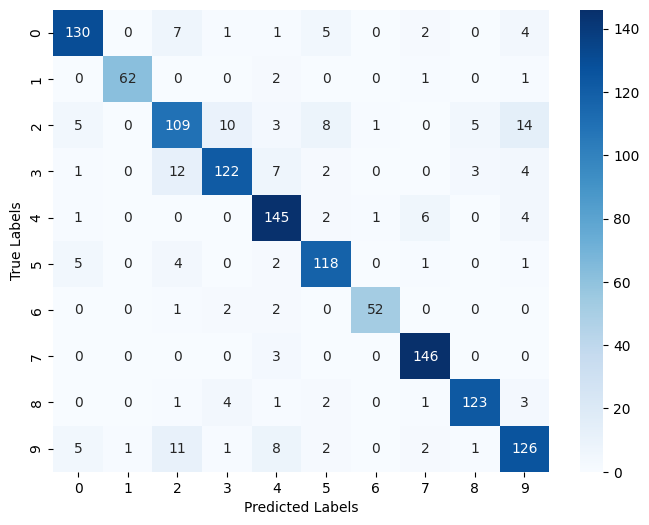

In [13]:
#Predict on test set
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())



#Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

#Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



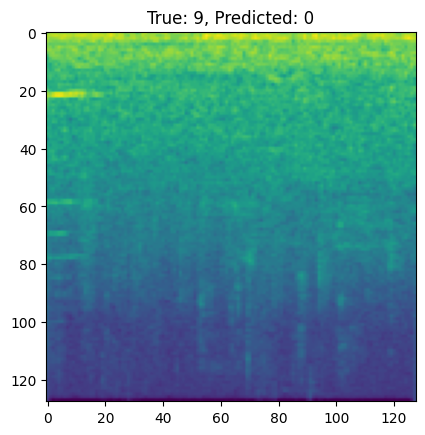

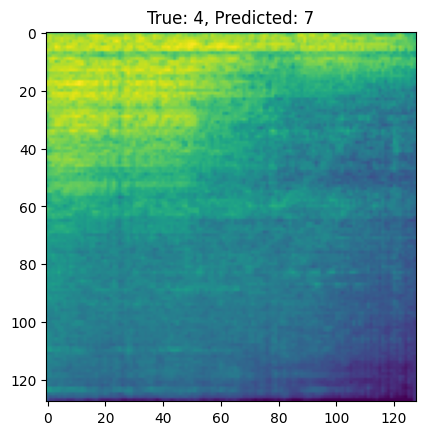

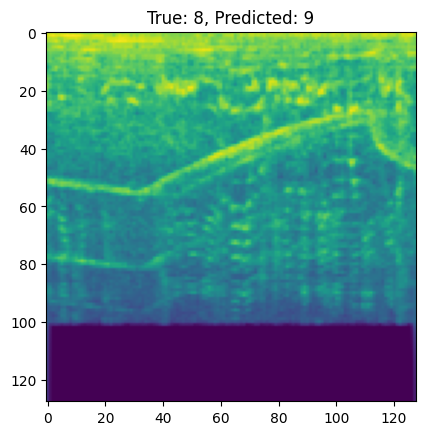

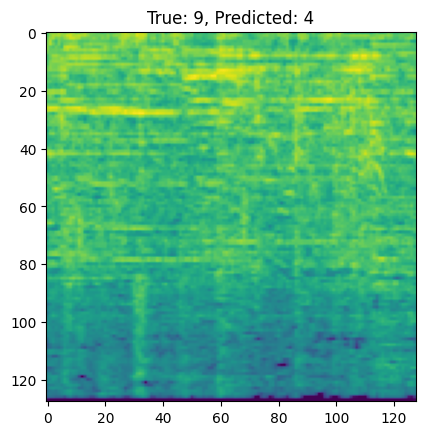

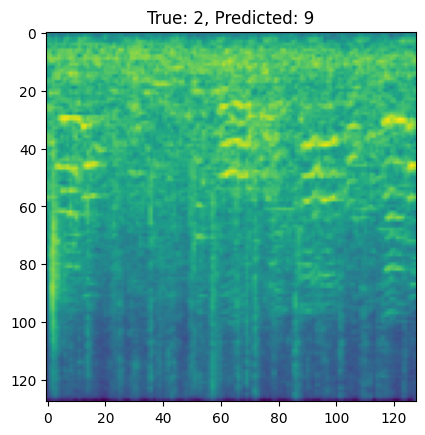

In [14]:
#Visualize misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]

for idx in misclassified_indices[:5]:  # Visualize first 5 misclassified samples
    plt.imshow(X_test[idx], cmap='viridis')
    plt.title(f"True: {all_labels[idx]}, Predicted: {all_preds[idx]}")
    plt.show()

In [15]:
class_names = [str(i) for i in range(10)]

#Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       150
           1       0.98      0.94      0.96        66
           2       0.75      0.70      0.73       155
           3       0.87      0.81      0.84       151
           4       0.83      0.91      0.87       159
           5       0.85      0.90      0.87       131
           6       0.96      0.91      0.94        57
           7       0.92      0.98      0.95       149
           8       0.93      0.91      0.92       135
           9       0.80      0.80      0.80       157

    accuracy                           0.86      1310
   macro avg       0.88      0.87      0.88      1310
weighted avg       0.86      0.86      0.86      1310

